## Contents
* read data
* drop redeundant columns
* one-hot encoding
* sliding window method
* identify response variable and predictors
* split into training and testing datasets
* data normalisation of training datasets
* define the model
* choose hyperparameters to tune
* identify the best hyperparameters using gridsearch
* make predictions based on these hyperparameters
* assess model performance 

In [125]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

In [126]:
base_dir = os.path.dirname(os.path.abspath("..\data"))
path = os.path.join(base_dir, r"data")
os.chdir(path) 

In [127]:
data = pd.read_csv("Cleaned data\data.csv")

In [128]:
# drop columns
df = data.drop(columns=[
    "DATE","FORECASTDEMAND","MONTHDATE","MIN","ACCMIN","MAX","ACCMAX","RAINPERIOD","QUANTITY","QUANTITYMONTHCUM","QUANTITYTOTALCUM","HUMIDITYMIN","HUMIDITYMAX", "RAIN", "WEEKEND"
], errors="ignore")
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,WEEKDAY,TEMPAVE
0,2016,1,1,0.656341,15.902439,6853.633437,2.0,32.2,38.472917,23.465,4,21.95
1,2016,1,2,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,23.465,5,21.00
2,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,23.465,6,21.55
3,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,23.465,0,20.90
4,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,23.465,1,19.05


In [129]:
#one hot encoding weekday
def one_hot_encode(df, col, names):
    array = np.array(df[col])
    integer_encoded = array.reshape(len(array), 1)
    onehotencoder = OneHotEncoder()
    onehot_encoded = onehotencoder.fit_transform(integer_encoded).toarray()
    df_encoded = pd.DataFrame(onehot_encoded, columns=names)
    df = pd.concat([df, df_encoded], axis=1)
    df = df.drop(columns=[col], errors="ignore")
    return df

df = one_hot_encode(df, col="WEEKDAY", names=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])
df.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,TEMPAVE,MON,TUE,WED,THU,FRI,SAT,SUN
0,2016,1,1,0.656341,15.902439,6853.633437,2.0,32.2,38.472917,23.465,21.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2016,1,2,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,23.465,21.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,23.465,21.55,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,23.465,20.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,23.465,19.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [130]:
def create_lags(df, lookback, columns):
    for col in columns:
        if col == "TOTALDEMAND":
            df["y"] = df[col].shift(-1) #response variable, total demand 1 day look ahead
        else:
            df[col+" (t+1)"] = df[col].shift(-1) #predictors, 1 day look ahead
        for i in range(lookback + 1):
            if i == 0: pass
            else: df[col+f" (t-{i})"] = df[col].shift(i) #i day/s look back 
    return df 

In [131]:
columns = ["HUMIDITY","WINDSPEED","TOTALDEMAND","HOLIDAY","SOLAR","RRP","OUTPUT","TEMPAVE"]
lookback = 1
df = create_lags(df, lookback, columns)
print(len(df))
df.head()

2376


,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,...,HOLIDAY (t+1),HOLIDAY (t-1),SOLAR (t+1),SOLAR (t-1),RRP (t+1),RRP (t-1),OUTPUT (t+1),OUTPUT (t-1),TEMPAVE (t+1),TEMPAVE (t-1)
0,2016,1,1,0.656341,15.902439,6853.633437,2.0,32.2,38.472917,23.465,...,0.0,NaN,21.7,NaN,36.907292,NaN,23.465,NaN,21.00,NaN
1,2016,1,2,0.656341,15.902439,6727.613958,0.0,21.7,36.907292,23.465,...,0.0,2.0,10.3,32.2,31.997083,38.472917,23.465,23.465,21.55,21.95
2,2016,1,3,0.688837,14.488372,6616.406076,0.0,10.3,31.997083,23.465,...,0.0,0.0,6.4,21.7,33.424583,36.907292,23.465,23.465,20.90,21.00
3,2016,1,4,0.679545,22.477273,7367.750278,0.0,6.4,33.424583,23.465,...,0.0,0.0,4.4,10.3,33.053958,31.997083,23.465,23.465,19.05,21.55
4,2016,1,5,0.768837,22.581395,7462.242014,0.0,4.4,33.053958,23.465,...,0.0,0.0,3.1,6.4,36.020417,33.424583,23.465,23.465,18.35,20.90


In [144]:
# train test split - use last year to train (data ends in 08/2022 so set timeframe as 08/2021 to 08/2022)
test_data = df.loc[np.where(((df['YEAR'] == 2021) & (df['MONTH'] > 7)) | (df['YEAR'] == 2022))]
test_len = len(test_data)
train_data = df.head(len(df)-test_len)
print(len(train_data), len(test_data))

2039 337


In [153]:
# Define window size and slide over training data
window_size = 10
step_size = 7
scaler = MinMaxScaler()
train_subseries = [train_data.iloc[i:i+window_size] for i in range(1, len(train_data)-window_size, step_size)]

# Extract features from sub-series
X_train = []
y_train = []
for subseries in train_subseries:
    X_scaled = pd.DataFrame(scaler.fit_transform(subseries.drop(["y"], axis=1)))
    X_scaled = X_scaled.mean(axis=0)   # feature extraction: mean of each column
    y = subseries.iloc[-1]['y']  # Last value in sub-series is target
    X_train.append(X_scaled)
    y_train.append(y)

# Train XGBoost model on extracted features
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Slide window over testing data and predict target values
test_subseries = [test_data.iloc[i:i+window_size] for i in range(1, len(test_data)-window_size, step_size)]
test_predictions = []
for subseries in test_subseries:
    X_scaled = pd.DataFrame(scaler.fit_transform(subseries.drop(["y"], axis=1)))
    X_scaled = X_scaled.mean(axis=0)  # feature extraction: mean of each column
    y_pred = model.predict([X_scaled])[0]
    test_predictions.append(y_pred)

# # Evaluate model performance on testing data
y_test = test_data.iloc[window_size:]['y'].values
# mse = mean_squared_error(X_test, test_predictions)


In [146]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

IndexError: tuple index out of range

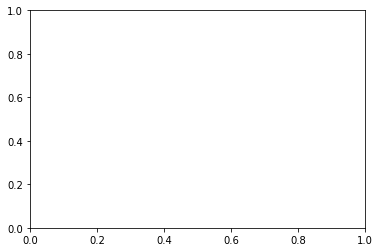

In [161]:
# Plot actual test values and predicted values
plt.plot(test_data.index[window_size:], y_test, label='Actual')
plt.plot(test_data.index[window_size:], test_predictions, label='Predicted')

# Set plot title and axis labels
plt.title('XGBoost Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Value')

# Add legend to plot
plt.legend()

# Display plot
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
# forecast = ax.plot(df.index, test_predictions, linewidth=1, color='red')
test = ax.plot(y_test.index, y_pred, linewidth=1, color='blue')
# ax.legend([test, forecast], labels=["Demand", "Forecast Demand"])
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax.set_title("Prior Forecast")
plt.show()